In [1]:
import numpy as np
#import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import scipy.sparse.linalg as sla
import numpy.linalg as la
import sys, os
import pickle
#import shapefile
import geopandas
import vista
#import rbf as RBF
import warnings

In [2]:
from FME import *

In [3]:
points = geopandas.read_file('data.gpkg',layer='points')
orientations = geopandas.read_file('data.gpkg',layer='orientations')
model_area = geopandas.read_file('data.gpkg',layer='bounding_box')

In [4]:
geom = model_area['geometry']#.shapes()
coords = np.array(geom[0].exterior.coords)#[0]
minz = -(np.max(coords[:,0])-np.min(coords[:,0]))/2.

In [5]:
boundary_points = np.zeros((2,3))
boundary_points[0,0] = np.min(coords[:,0])
boundary_points[0,1] = np.min(coords[:,1])
boundary_points[0,2] = minz
boundary_points[1,0] = np.max(coords[:,0])
boundary_points[1,1] = np.max(coords[:,1])
boundary_points[1,2] = -minz*0.1
mesh = TetMesh('NoddySingleFold',)
mesh.setup_mesh(boundary_points,nstep=1,n_tetra=50000,)
regionmanager = RegionManager(mesh)
cg = mesh.get_constant_gradient(region=mesh.regions['everywhere'],shape='square')
mesh.save()

Text(0.5, 1.0, 'Bedding and S0 observations')

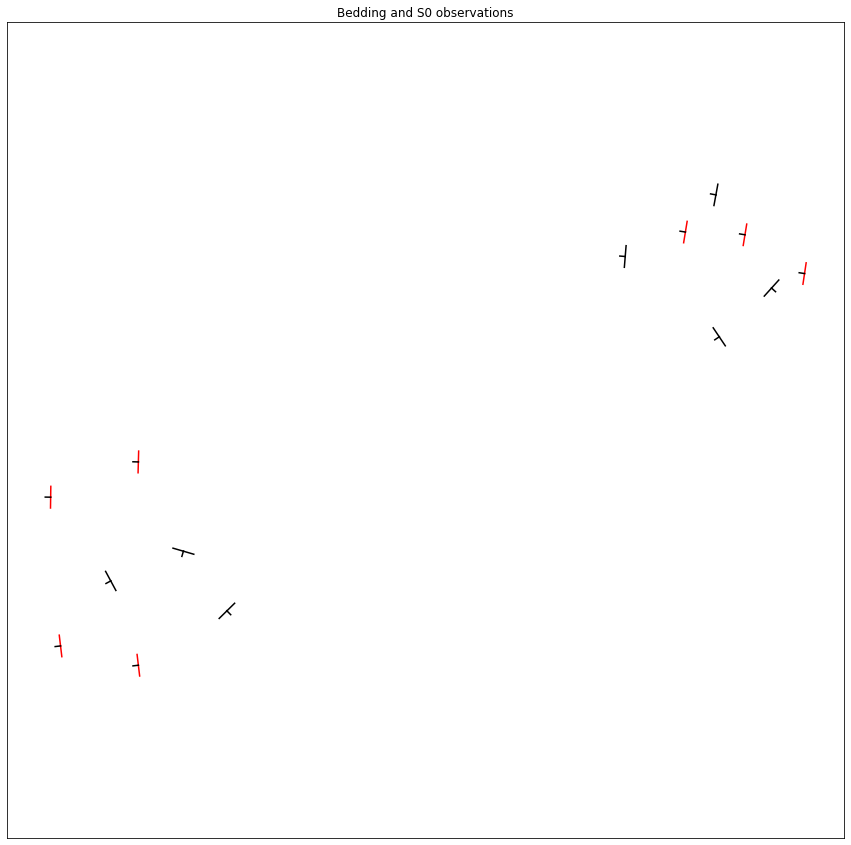

In [6]:
def strike_symbol(strike):
    R = np.zeros((2,2))
    R[0,0] = np.cos(np.deg2rad(-strike))
    R[0,1] = -np.sin(np.deg2rad(-strike))
    R[1,0] = np.sin(np.deg2rad(-strike))
    R[1,1] = np.cos(np.deg2rad(-strike)) 
    R = np.zeros((2,2))
    R[0,0] = np.cos(np.deg2rad(-strike))
    R[0,1] = -np.sin(np.deg2rad(-strike))
    R[1,0] = np.sin(np.deg2rad(-strike))
    R[1,1] = np.cos(np.deg2rad(-strike))
    
    vec = np.array([0,1])
    rotated = R@vec
    vec2 = np.array([-0.5,0])
    r2 = R@vec2
    return rotated,r2
def plot_strike(x,y,strike,scale=100,colour='black'):
    rotated, r2 = strike_symbol(-strike)
    rotated*=scale
    r2*=scale
    plt.plot([x,x+rotated[0]],[y,y+rotated[1]],colour)
    plt.plot([x-rotated[0],x],[y-rotated[1],y],colour)
    plt.plot([x,x+r2[0]],[y,y+r2[1]],'k-')


plt.figure(figsize=(15,15))
for i,o in orientations.iterrows():
    if o['type'] == 's1' and o['itype'] =='gx':#print(o)
        plot_strike(o['geometry'].xy[0][0],o['geometry'].xy[1][0],o['strike'],colour='red')
    if o['type'] == 's0':
        plot_strike(o['geometry'].xy[0][0],o['geometry'].xy[1][0],o['strike'],colour='black')
plt.gca().get_yaxis().set_visible(False)#axis('equal')
plt.gca().get_xaxis().set_visible(False)#axis('equal')
plt.axis('equal')
plt.title('Bedding and S0 observations')

In [7]:
fold_f1 = FoldFrame(mesh=mesh,region='everywhere',shape='square',name='Fold_f1')
for i, r in orientations.iterrows():
    if r['type'] == 's1':
        xy = r['geometry'].xy
        z = 0
        if 'z' in r:
            z = r['z']
        fold_f1.add_strike_and_dip([xy[0][0],xy[1][0],z],r['strike'],r['dip'],itype=r['itype'])
for i, r in points.iterrows():
    if r['type'] == 's1':
        xy = r['geometry'].xy
        z = 0
        if 'z' in r:
            z = r['z']
        fold_f1.add_point([xy[0][0],xy[1][0],z],r['value'],itype=r['itype'])

fold_f1.buildFrame(solver='chol')

Setting up interpolator with 1 value control points 
        7 gradient control points and 0 tangent control points and 
        constant gradient regularization with a weight of 0.100000
Setting up interpolator with 1 value control points 
        7 gradient control points and 0 tangent control points and 
        constant gradient regularization with a weight of 0.000000


In [ ]:
def semivariogram(self,lags,tol,distance,covariance):
        variance = np.zeros(len(lags))
        npairs = np.zeros(len(lags))
        self.min_ = np.zeros(len(lags))
        self.max_ = np.zeros(len(lags))
        for i in range(len(lags)):
            ma = np.ma.array(data = covariance, mask =inside(distance,
                lags[i]-tol/2.,lags[i]+tol/2.))
            if len(ma[~ma.mask])>0:
                variance[i] = np.mean(ma[~ma.mask])     
                self.min_[i] = np.percentile(ma[~ma.mask],25)
                self.max_[i] = np.percentile(ma[~ma.mask],75)
            else:
                variance[i] = np.nan
                self.min_[i] = np.nan
                self.max_[i] = np.nan
            npairs[i] = ma.count()
        return variance,npairs
    def find_wavelengths(self,step=0,nlags=0):

        if step==0:
            minxx = np.min(self.xdata)
            maxx = np.max(self.xdata)
            sorted_x = np.sort(self.xdata)
            av_dist = 0.
            c = 0
            dist = 0
            for i in range(len(self.xdata)):
                if i ==0:
                    dist += sorted_x[i+1]-sorted_x[i]
                    c+=1
                if i == len(self.xdata)-1:
                    dist += sorted_x[i]-sorted_x[i-1]
                    c+=1
                else:
                    dist += sorted_x[i]-sorted_x[i-1]
                    dist += sorted_x[i+1]-sorted_x[i]
                    c+=2

            step = dist /c #abs((float((maxx - minxx)) / float(len(self.xdata))))
            step*=1.2
        if nlags == 0:
            distance = np.abs(np.min(self.xdata)-np.max(self.xdata))
            nlags = (distance / step)
        self.h, self.var, self.npairs = self.calc_semivariogram(step,nlags,step)

        self.px, self.py = self.find_peaks_and_troughs(self.h,self.var)
        
        self.averagex = []
        self.averagey = []
        for i in range(len(self.px)-1):
            self.averagex.append((self.px[i]+self.px[i+1])/2.)
            self.averagey.append((self.py[i]+self.py[i+1])/2.)
            i+=1 #iterate twice
        #find the extrema of the average curve
        self.px2, self.py2 = self.find_peaks_and_troughs(self.averagex,self.averagey)
        self.wl1 = 0.
        wl1py = 0.
        for i in range(len(self.px)):
            if i > 0 and i < len(self.px)-1:
                if self.py[i] > 10:
                    
                    if self.py[i-1] < self.py[i]*.7:
                        if self.py[i+1] < self.py[i]*.7:
                            self.wl1 = self.px[i]
                            if self.wl1 > 0.:
                                wl1py = self.py[i]
                                break
        self.wl2 = 0.
        for i in range(len(self.px2)):
            if i > 0 and i < len(self.px2)-1:
                if self.py2[i-1] < self.py2[i]*.90:
                    if self.py2[i+1] < self.py2[i]*.90:
                        self.wl2 = self.px2[i]
                        if self.wl2 > 0. and self.wl2 > self.wl1*2 and wl1py < self.py2[i]:
                            
                            break
        if self.wl1 == 0.0 and self.wl2 == 0.0:
            return 0.0, 2*(maxx-minxx)
        return self.wl1*2., self.wl2*2.
    def find_peaks_and_troughs(self,x,y):
        if len(x) != len(y):
            return False
        pairsx = []
        pairsy = []
        for i in range(0,len(x)):
            if i < 1:
                pairsx.append(x[i])
                pairsy.append(y[i])

                continue
            if i > len(x)-2:
                pairsx.append(x[i])
                pairsy.append(y[i])
                continue
            left_grad = (y[i-1]-y[i]) / (x[i-1]-x[i])
            right_grad = (y[i]-y[i+1]) / (x[i]-x[i+1])
            if np.sign(left_grad) != np.sign(right_grad):
                pairsx.append(x[i])
                pairsy.append(y[i])
        return pairsx,pairsy

In [56]:
from scipy.spatial.distance import pdist,squareform
dist = squareform(pdist(np.array([s1gy]).T))
max_dist = np.max(dist)
dist[dist==0] = 9999
step = np.mean(np.min(dist,axis=1))/2.
#print(steps,max_dist)
steps = np.arange(0,max_dist,step)


steps2 = np.arange(step,max_dist+step,step)
steps=np.vstack([[steps],[steps2]])

In [58]:
#print(steps)

dist[np.logical_and(dist>steps[0,:],dist<steps[1,:])]

ValueError: operands could not be broadcast together with shapes (7,7) (20,) 

MaskError: Mask and data not compatible: data size is 49, mask size is 7.

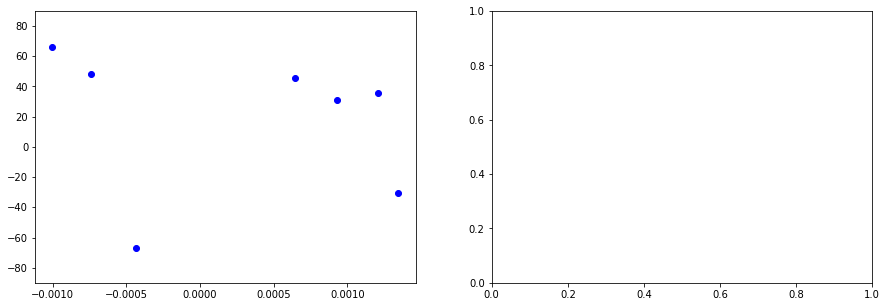

In [14]:
#from helper import strike_dip_vector
nans = np.zeros(len(orientations))
nans[:] = np.nan
orientations['x'] = nans
orientations['y'] = nans
orientations['z'] = nans
for i,r in orientations.iterrows():
    orientations.at[i,'x'] = r['geometry'].xy[0][0]
    orientations.at[i,'y'] = r['geometry'].xy[1][0]
    orientations.at[i,'z'] = 0.0
s0 = orientations[orientations['type'] == 's0']
xyz = s0.loc[:,['x','y','z']].as_matrix()
s0g = strike_dip_vector(s0.loc[:,'strike'],s0.loc[:,'dip'])
s0g /= np.linalg.norm(s0g,axis=1)[:,None]
l1 = fold_f1.calculate_intersection_lineation(np.hstack([xyz,s0g]))
far = fold_f1.calculate_fold_axis_rotation(np.hstack([xyz,l1]))                                        
s1 = fold_f1.get_gx(xyz,grad=False)
s1gy = fold_f1.get_gy(xyz,grad=False)

##quick figure
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(s1gy,far,'bo')
ax[0].set_ylim(-90,90)
#ax[0].ylim(-90,90)
svario = s_variogram(s1gy,far)
svario.setup()
#guess = [.04000]
guess = svario.find_wavelengths()
ax[1].plot(svario.h,svario.var,'bo')
#ax[1].axvline(guess[0])

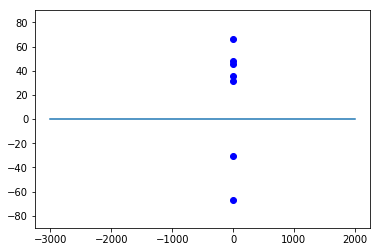

In [10]:
from scipy.interpolate import Rbf
far_tan = np.tan(np.deg2rad(far))
rbf_fold_axis = Rbf(s1gy,np.zeros(s1gy.shape),np.zeros(s1gy.shape),far_tan,function='gaussian',epsilon=guess[0],smooth=.1)
xi = np.linspace(-3000,2000,1000)
plt.plot(xi,np.rad2deg(np.arctan(rbf_fold_axis(xi,np.zeros(1000),np.zeros(1000)))))
plt.plot(s1gy,far,'bo')
plt.ylim(-90,90)
def fold_axis_rotation(x):
    return np.rad2deg(np.arctan(rbf_fold_axis(x,np.zeros(x.shape),np.zeros(x.shape))))

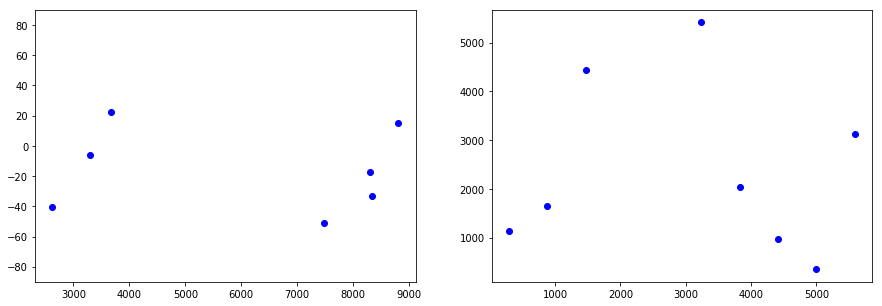

In [12]:
fold = FoldEvent(fold_f1,fold_axis_rotation,None)
axis = fold.get_fold_axis_orientation(xyz)
axis/=np.linalg.norm(axis,axis=1)[:,None]
flr = fold_f1.calculate_fold_limb_rotation(np.hstack([xyz,s0g]),axis=axis)
##quick figure
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(s1,flr,'bo')
ax[0].set_ylim(-90,90)
#ax[0].ylim(-90,90)
svario = s_variogram(s1,flr)
svario.setup()
guess = svario.find_wavelengths()
ax[1].plot(svario.h,svario.var,'bo')
#ax[1].axvline(guess[1])
guess = np.array(guess)
guess[0] = 2500

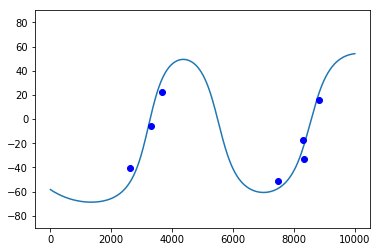

In [13]:
flr_tan = np.tan(np.deg2rad(flr))
rbf_fold_limb = Rbf(s1,np.zeros(s1.shape),np.zeros(s1.shape),flr_tan,function='gaussian',epsilon=guess[0],smooth=.05)
xi = np.linspace(0,10000,1000)
plt.plot(xi,np.rad2deg(np.arctan(rbf_fold_limb(xi,np.zeros(1000),np.zeros(1000)))))
plt.plot(s1,flr,'bo')
plt.ylim(-90,90)
def fold_limb_rotation(x):
    return np.rad2deg(np.arctan(rbf_fold_limb(x,np.zeros(x.shape),np.zeros(x.shape))))

In [14]:
#update the fold event to have a real fold_limb_rotation function
fold.fold_limb_rotation = fold_limb_rotation
const = DSIFoldConstraint(fold,mesh,shape='square') 
const.use_deformed_orientation_cnstrt(50.) 
const.use_fold_axis_cnstrt(3.) 
const.use_regularisation_cnstrt(10.) 
const.use_normalisation_cnstrt()

A, B, row, col = const.get_constraints()
deformed_orientation, fold_axis, dgz = fold.get_deformed_orientation(mesh.barycentre)
mesh.property_gradients['fold'] = deformed_orientation 
mesh.property_gradients['axis'] = fold_axis 
mesh.update_property('foldrot',fold_limb_rotation(mesh.properties[fold_f1.interpolators['gx'].propertyname]))

In [15]:
stratigraphy = DSI(mesh,region='everywhere',shape='square',solver='chol')
stratigraphy.add_point([70.1,0.1,1.1],0.)
stratigraphy.setup_interpolator(cg=False,cgw=0.)
stratigraphy.A.extend(A)
stratigraphy.row.extend(row)
stratigraphy.col.extend(col)
stratigraphy.B+=B
stratigraphy.solve_system(solver='chol',clear=True)
mesh.update_property('strati',stratigraphy.c)

Setting up interpolator with 1 value control points 
        0 gradient control points and 0 tangent control points and 
        constant gradient regularization with a weight of 0.000000


### Plot resulting model

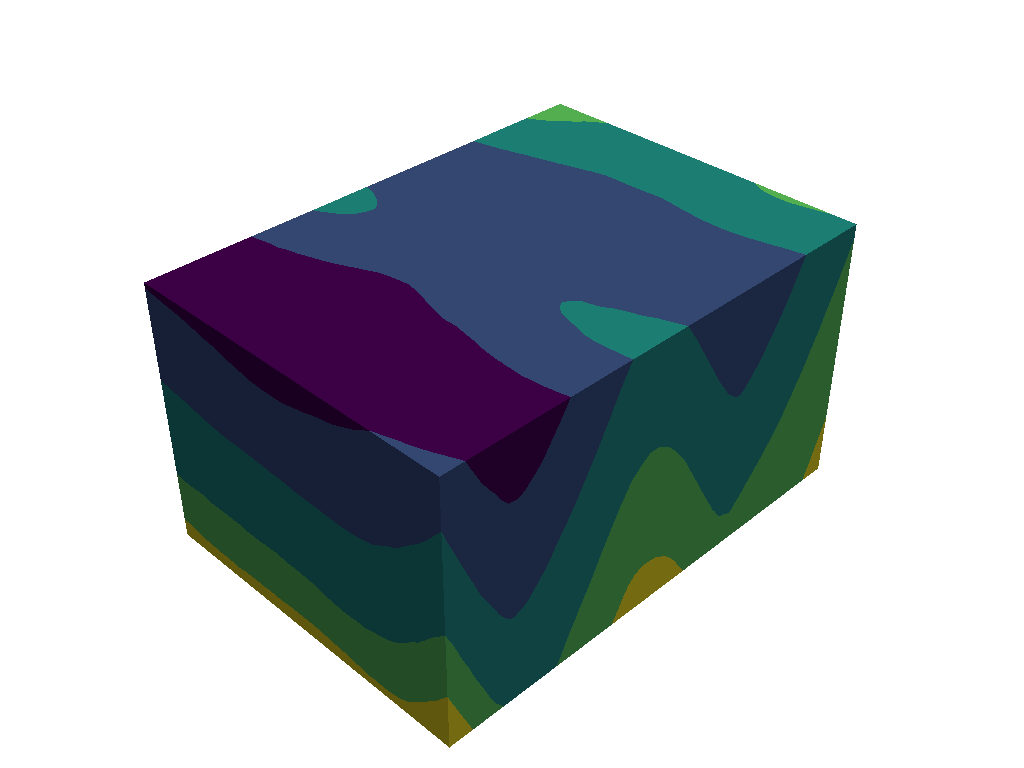

In [22]:
plot_mesh(mesh,'strati',strati)